<h2 align="center">Sentiment Analysis</h2>

In [96]:
import numpy as np
import pandas  as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from textblob import TextBlob
from wordcloud import wordcloud
import seaborn as sns
import matplotlib.pyplot as plt
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
cf.go_offline();
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('Reviews.csv')
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

In [5]:
df['Cleaned_Text'] = df['Text'].apply(clean_text)

In [30]:
def missing_values_analysis(df):
    columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    total = df[columns].isnull().sum().sort_values(ascending=True)
    percent = (df[columns].isnull().sum()/df.shape[0]*100).sort_values(ascending=True)
    missing_data = pd.concat([total, np.round(percent,3)], axis=1, keys=['Total', 'Percent'])
    missing_data = pd.DataFrame(missing_data)
    return missing_data

def data_summary(df):
    print("Shape of the Dataset".center(80, '-'))
    print("Rows : ",df.shape[0])
    print("Columns : ",df.shape[1])
    print("Types".center(80, '-'))
    print(df.dtypes)
    print("Columns with Missing Values".center(80, '-'))
    print(missing_values_analysis(df))
    print("Duplicate Values".center(80, '-'))
    print(df.duplicated().sum())
    print("Quantiles".center(80, '-'))
    print(df.quantile([0.25,0.5,0.75]).T)

In [31]:
data_summary(df)

------------------------------Shape of the Dataset------------------------------
Rows :  568454
Columns :  11
-------------------------------------Types--------------------------------------
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
Cleaned_Text              object
dtype: object
--------------------------Columns with Missing Values---------------------------
             Total  Percent
ProfileName     16    0.003
Summary         27    0.005
--------------------------------Duplicate Values--------------------------------
0
-----------------------------------Quantiles------------------------------------
                                0.25          0.50          0.75
Id                      1.421142e+05  

In [34]:
def unique_values(df):
    unique_df = pd.DataFrame({'Columns':df.columns, 'Unique_Values':[df[col].nunique() for col in df.columns]})
    unique_df = unique_df.sort_values(by='Unique_Values', ascending=False)
    unique_df = unique_df.reset_index(drop=True)
    return unique_df

In [35]:
unique_values(df)

,Columns,Unique_Values
0,Id,568454
1,Text,393579
2,Cleaned_Text,393121
3,Summary,295742
4,UserId,256059
5,ProfileName,218416
6,ProductId,74258
7,Time,3168
8,HelpfulnessDenominator,234
9,HelpfulnessNumerator,231


In [78]:
colors = ['#B34D22','#EBE00C','#1FEB0C','#0C92EB','#EB0CD5']
def columns_summary(df,col):
    fig = make_subplots(rows=1,
                        cols=2 ,
                        subplot_titles=('Countplot','Percentage'),
                        specs=[[{'type':'bar'}, {'type':'pie'}]])
    fig.add_trace(go.Bar(y=df[col].value_counts().values.tolist(),
                         x=[str(i) for i in df[col].value_counts().index],
                         text = df[col].value_counts().values.tolist(),
                         textfont=dict(size=14),
                         name=col,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC', width=1))),
    row=1, col=1)
    fig.add_trace(go.Pie(labels=df[col].value_counts().index.tolist(),
                         values=df[col].value_counts().values,
                         textfont=dict(size=14),
                         name=col,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(colors=colors)),
                  row=1, col=2)
    fig.update_layout(title={'text':col,
                             'y':0.9,
                             'x':0.5,
                             'xanchor':'center',
                             'yanchor':'top'},
                      template='plotly_white')
    iplot(fig)

In [79]:
columns_summary(df,'Score')

In [81]:
df[['Text','Cleaned_Text']].head(3)

,Text,Cleaned_Text
0,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,This is a confection that has been around a fe...,this is a confection that has been around a fe...


In [113]:
sia = SentimentIntensityAnalyzer()

In [99]:
# Running polarity score on the whole dataset

res = {}
for i, row in tqdm(df.iterrows()):
    myid = row['Id']
    text = row['Text']
    res[myid] = sia.polarity_scores(text)
    

0it [00:00, ?it/s]

In [108]:
vaders = pd.DataFrame.from_dict(res, orient='index')
vaders = vaders.reset_index().rename(columns={'index':'Id'})
vaders.head(3)

,Id,neg,neu,pos,compound
0,1,0.000,0.695,0.305,0.9441
1,2,0.138,0.862,0.000,-0.5664
2,3,0.091,0.754,0.155,0.8265


In [109]:
# merging the vader scores with the original dataset
vaders = vaders.merge(df, on='Id',how='left')
vaders.head(3)

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...


## Plotting Vader Results

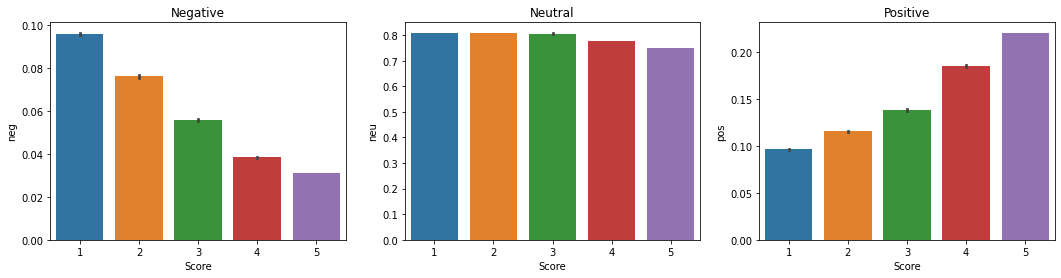

In [112]:
fig,axs = plt.subplots(1,3,figsize=(18,4))
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[2])
axs[0].set_title('Negative')
axs[1].set_title('Neutral')
axs[2].set_title('Positive')
plt.show()